In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.optimizers.rmsprop import RMSprop
from keras.optimizers.adam import Adam
from keras.optimizers import SGD

%matplotlib inline

Загрузка данных и разделение на train и test

In [59]:
(X_train, y_train_labels), (X_test, y_test_labels) = fashion_mnist.load_data()

print(X_train.shape, X_test.shape)
print(y_train_labels.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,)


Сгенерируем случайный индекс в диапазоне от 0 до 60000 и отрисуем картинку

Label is 7


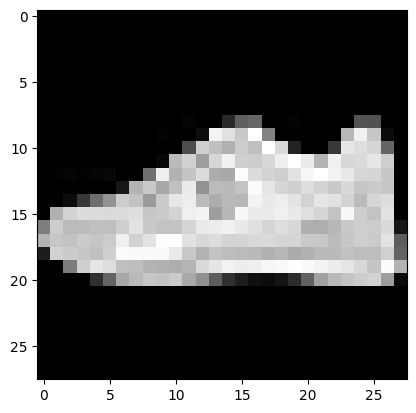

In [60]:
ind = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[ind], cmap='gray')

print(f'Label is {y_train_labels[ind]}')

In [61]:
X_train.min(), X_train.max()

(0, 255)

Выполним нормировку

In [62]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train.min(), X_train.max()

(0.0, 1.0)

Разложим картинку в один длинный вектор

In [63]:
X_train = X_train.reshape((-1, 28 * 28))
X_test = X_test.reshape((-1, 28 * 28))

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [64]:
y_train_labels[:5]

array([9, 0, 0, 3, 0], dtype=uint8)

In [65]:
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Построим модели с количеством скрытых слоёв от 1 до 64

In [66]:
%%time
results_num = pd.DataFrame()
n_nums = []
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []


for n_num in list(map(lambda x: 2**x, range(0,7))):
    
    n_nums.append(n_num)
    
    model = Sequential([
        Dense(64, input_shape=(28 * 28,), activation='relu'),
        Dense(n_num, activation='relu'),
        Dense(10, activation='sigmoid')
    ])

    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    verbose=1,
                    validation_data=(X_test, y_test)
                    )
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=64)
    train_losses.append(train_loss)
    train_metrics.append(train_metric)
    test_loss, test_metric = model.evaluate(X_test, y_test, batch_size=64)
    test_losses.append(test_loss)
    test_metrics.append(test_metric)
    
    
results_num['n_num'] = n_nums
results_num['train_loss'] = train_losses
results_num['test_loss'] = test_losses
results_num['train_metric'] = train_metrics
results_num['test_metric'] = test_metrics
results_num.sort_values(by='test_metric', ascending=False)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_198 (Dense)           (None, 64)                50240     
                                                                 
 dense_199 (Dense)           (None, 1)                 65        
                                                                 
 dense_200 (Dense)           (None, 10)                20        
                                                                 
Total params: 50,325
Trainable params: 50,325
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
938/938 [==============================] - 4s 4ms/step - loss: 2.3028 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 2.3027 - accuracy: 0.0971 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/5
938/938 [============

,n_num,train_loss,test_loss,train_metric,test_metric
4,16,0.446425,0.479643,0.846067,0.8336
5,32,0.445981,0.478433,0.844983,0.8319
6,64,0.445708,0.479453,0.843900,0.8313
3,8,0.515090,0.544687,0.820283,0.8076
2,4,0.638751,0.663778,0.776550,0.7669
1,2,1.059178,1.080847,0.601317,0.5948
0,1,2.302590,2.302591,0.100000,0.1000


При количестве нейронов 64 в скрытом слое модель показала наилучший результат. Потери на train и test минимальны, а метрика максимальна

# Демонстрация полученных результатов

Посмотрим на точность в зависимости от обучения

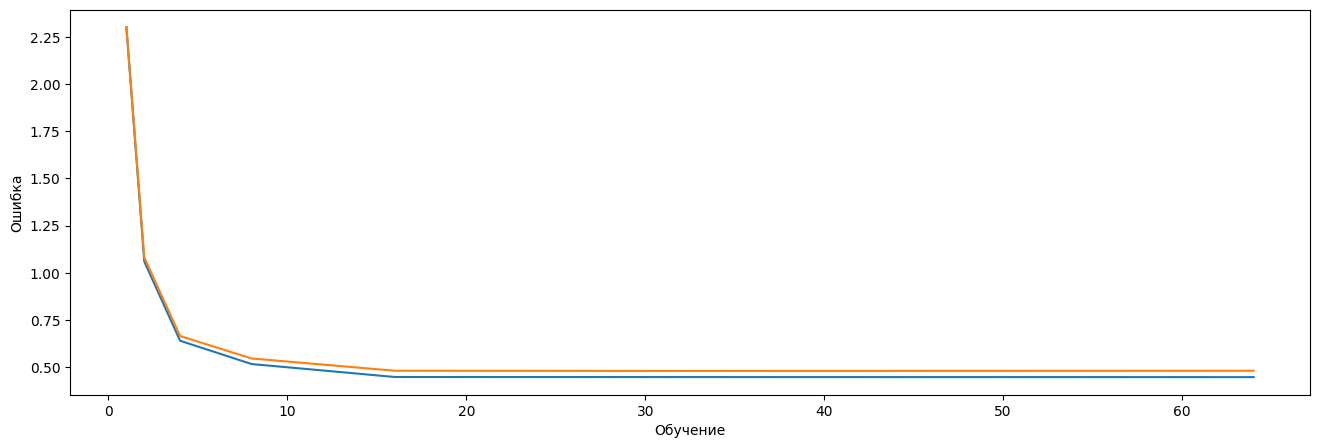

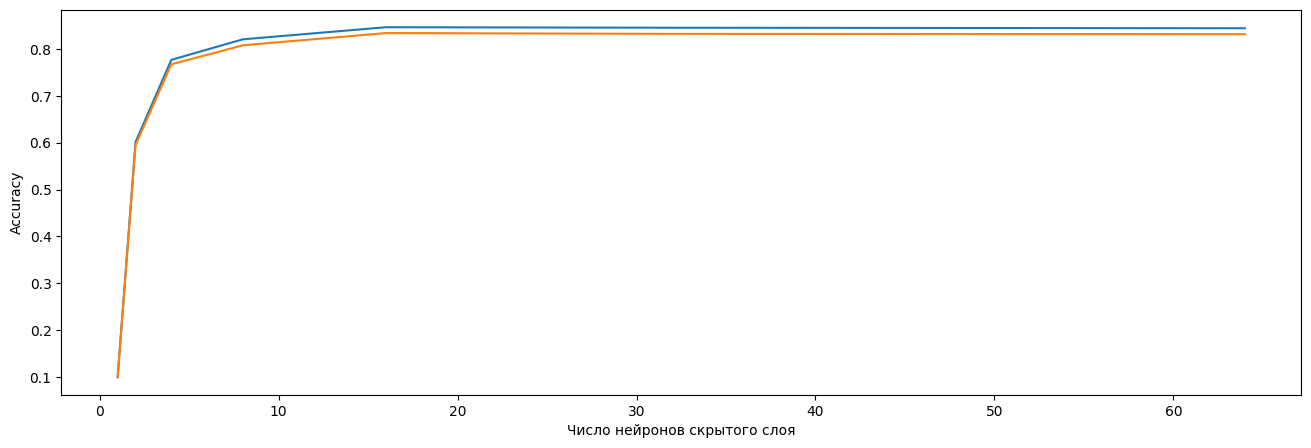

In [67]:
plt.figure(figsize=(16, 5))
plt.plot(results_num['n_num'],results_num['train_loss'], label='train')
plt.plot(results_num['n_num'],results_num['test_loss'], label='test')
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(results_num['n_num'],results_num['train_metric'], label='train')
plt.plot(results_num['n_num'],results_num['test_metric'], label='test')
plt.xlabel('Число нейронов скрытого слоя')
plt.ylabel('Accuracy')
plt.show()

При количестве нейронов 16 качество модели не сильно изменяется

Проверим качество в зависимости от числа слоев (2, 3, 5, 10) при близких размерах сети

In [68]:
%%time
results_layers = pd.DataFrame()
n_nums = [] # число нейронов скрытых слоев
n_layers = [] # число скрытых слоев
n_pars = [] # число тренируемых параметров
train_losses = [] # ошибка на тренировочной выборке
test_losses = [] # ошибка на тестовой выборке
train_metrics = [] # accuracy на тренировочной выборке
test_metrics = [] # accuracy на тестовой выборке

# Базовый размер возьмем для двухслойной сети с 128 нейронами и будем равняться на него
k_dict = {2:128, 3:67, 5:45, 10:30}
for n in [2, 3, 5, 10]:
    
    k = k_dict[n]
    net_size = 64 * 785 + 65 * k + (n - 2) * (k + 1) * k + (k + 1) * 10
    n_nums.append(k) 
    n_pars.append(net_size)
    n_layers.append(n)
    
    model = Sequential()
    model.add(Dense(64, input_shape=(28 * 28,), activation='relu'))

    for i in range(n-1):
        model.add(Dense(k, activation='relu'))
    model.add(Dense(10, activation='sigmoid'))

    model.summary()

    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    verbose=1,
                    validation_data=(X_test, y_test)
                    )
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=64)
    train_losses.append(train_loss)
    train_metrics.append(train_metric)
    test_loss, test_metric = model.evaluate(X_test, y_test, batch_size=64)
    test_losses.append(test_loss)
    test_metrics.append(test_metric)
    
    
results_layers['n_layer'] = n_layers
results_layers['n_num'] = n_nums
results_layers['n_par'] = n_pars
results_layers['train_loss'] = train_losses
results_layers['test_loss'] = test_losses
results_layers['train_metric'] = train_metrics
results_layers['test_metric'] = test_metrics
results_layers.sort_values(by='test_metric', ascending=False)

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_219 (Dense)           (None, 64)                50240     
                                                                 
 dense_220 (Dense)           (None, 128)               8320      
                                                                 
 dense_221 (Dense)           (None, 10)                1290      
                                                                 
Total params: 59,850
Trainable params: 59,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
938/938 [==============================] - 4s 4ms/step - loss: 1.0000 - accuracy: 0.6727 - val_loss: 0.6726 - val_accuracy: 0.7599
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.5845 - accuracy: 0.7994 - val_loss: 0.5648 - val_accuracy: 0.8015
Epoch 3/5
938/938 [============

,n_layer,n_num,n_par,train_loss,test_loss,train_metric,test_metric
1,3,67,59831,0.430136,0.463007,0.847617,0.8361
0,2,128,59850,0.468570,0.503385,0.831050,0.8159
2,5,45,59835,0.503518,0.539597,0.815833,0.8005
3,10,30,59940,0.508751,0.546533,0.818933,0.8005


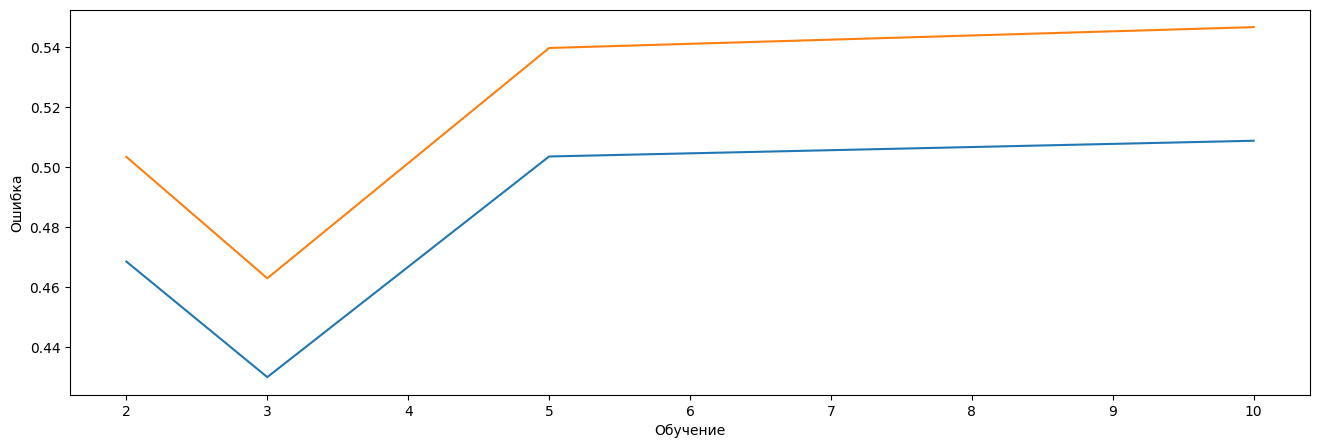

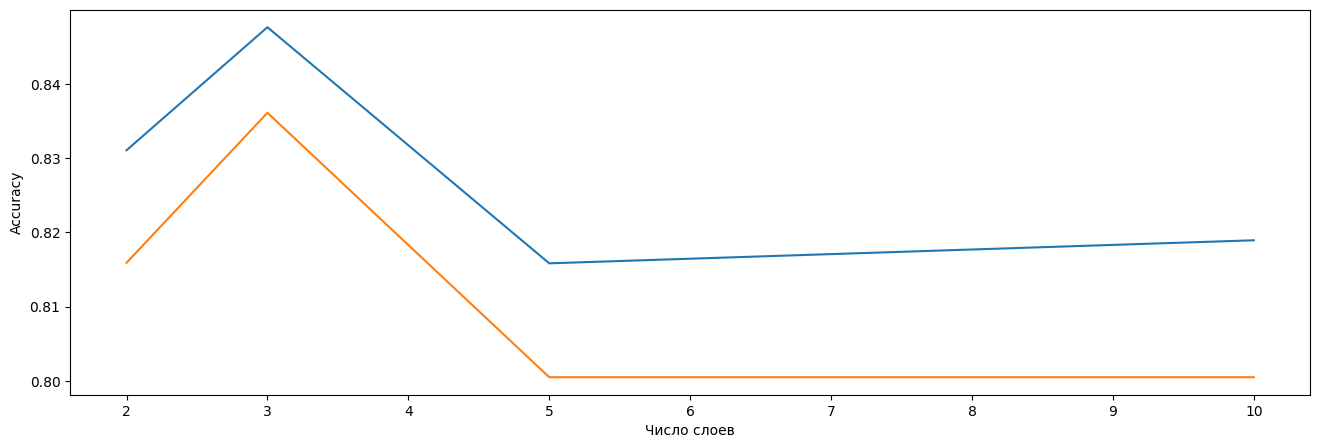

In [69]:
plt.figure(figsize=(16, 5))
plt.plot(results_layers['n_layer'],results_layers['train_loss'], label='train')
plt.plot(results_layers['n_layer'],results_layers['test_loss'], label='test')
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(results_layers['n_layer'],results_layers['train_metric'], label='train')
plt.plot(results_layers['n_layer'],results_layers['test_metric'], label='test')
plt.xlabel('Число слоев')
plt.ylabel('Accuracy')
plt.show()

3 слоя с 67 нейронами показали лучший результат. Посмотрим работу разных оптимизаторов для этой модели

Оптимизатор: SGD
Epoch 1/5
938/938 [==============================] - 4s 4ms/step - loss: 1.0497 - accuracy: 0.6436 - val_loss: 0.6911 - val_accuracy: 0.7377
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.5798 - accuracy: 0.7954 - val_loss: 0.6208 - val_accuracy: 0.7794
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.5108 - accuracy: 0.8210 - val_loss: 0.6588 - val_accuracy: 0.7732
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.4742 - accuracy: 0.8324 - val_loss: 0.5040 - val_accuracy: 0.8209
Epoch 5/5
157/157 [==============================] - 0s 2ms/step - loss: 0.4696 - accuracy: 0.8346
Качество на тесте: 0.46961334347724915, 0.8345999717712402

Оптимизатор: RMSprop
Epoch 1/5
938/938 [==============================] - 5s 4ms/step - loss: 0.5707 - accuracy: 0.7923 - val_loss: 0.4232 - val_accuracy: 0.8458
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.3965 - accuracy: 0.8540

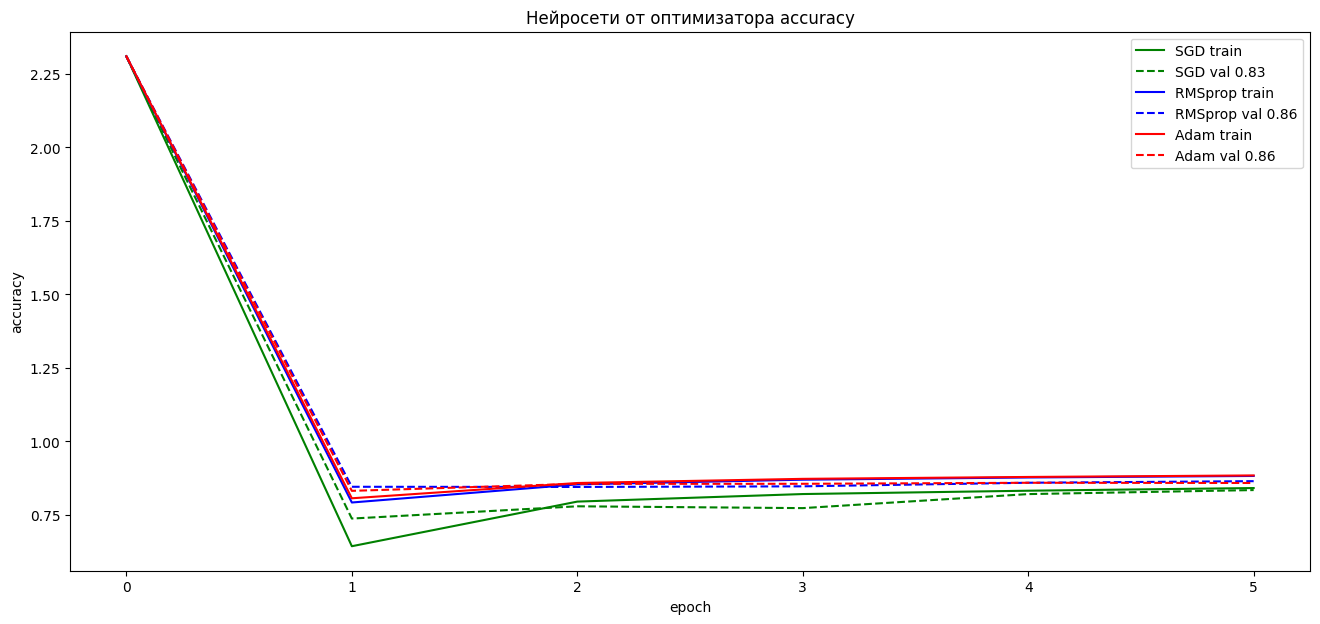

CPU times: user 1min 23s, sys: 4.57 s, total: 1min 28s
Wall time: 1min 24s


In [71]:
%%time

# создаем модель model
model = Sequential([
    Dense(64, activation='relu', input_shape=(28 * 28,)),
    Dense(67, activation='relu'),
    Dense(67, activation='relu'),
    Dense(67, activation='relu'),
    Dense(10, activation='sigmoid'),
])

# сохраняем ее веса (это начальная точка)
model.save_weights('model_weights.h5')

# будем сохранять модели в словарь
models = {}

plt.figure(figsize=(16, 7))
colors = ['g', 'b', 'r']

num_epochs = 5
batch_size = 64

# вектор для вывода результатов
epoch = np.arange(num_epochs+1)

# будем изменять оптимизаторы
for i, i_optim in enumerate([SGD(),
                             RMSprop(),
                             Adam()]):
    print(f'Оптимизатор: {i_optim.get_config()["name"]}')
    
    # создаем рабочую модель  model_i, куда будем загружать эти веса
    model_i = Sequential([
        Dense(64, activation='relu', input_shape=(28 * 28,)),
        Dense(67, activation='relu'),
        Dense(67, activation='relu'),
        Dense(67, activation='relu'),
        Dense(10, activation='sigmoid'),
    ])
    
    # загружаем веса model_i.load_weights('model.h5')
    model_i.load_weights('model_weights.h5')
    
    # компилируем model_i с одним из оптимизаторов
    model_i.compile(
        optimizer=i_optim,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )
    
    # вычисляем ошибку для model_i без обучения
    h0_train = model_i.evaluate(X_train, y_train, verbose=0)
    h0_val = model_i.evaluate(X_test, y_test, verbose=0)

    # проводим обучение модели 
    h = model_i.fit(X_train, y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    verbose=1)
    
    # вычисляем ошибку для model_i после обучения
    loss, metric = model_i.evaluate(X_test, y_test, batch_size=64)
    print(f'Качество на тесте: {loss}, {metric}\n')
    
    # записываем обученную модель в словарь
    models[i_optim.get_config()['name']] = model_i

    
    # картинки
    plt.plot(epoch, ([h0_train[0]] + h.history['accuracy']),
             '-', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' train')
    plt.plot(epoch, ([h0_val[0]] + h.history['val_accuracy']),
             '--', c=colors[i],
             label=f'{model_i.optimizer.get_config()["name"]} val {metric:.2f}')

plt.legend()
plt.title('Нейросети от оптимизатора accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()